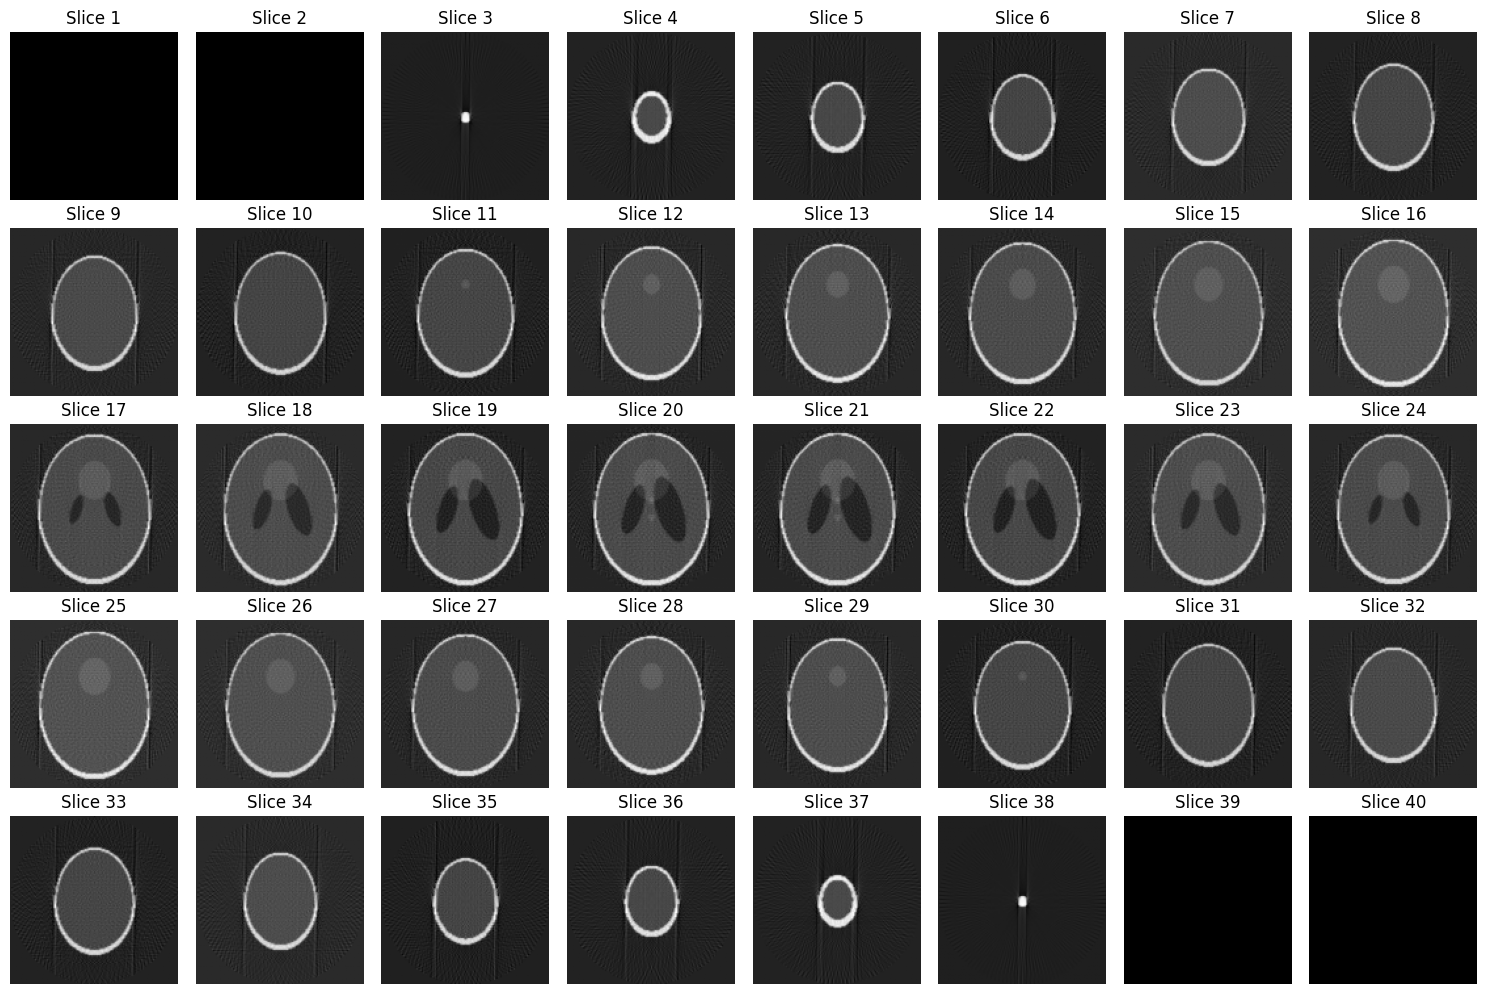

All 40 slices saved in 'reconstructed_slices' folder.


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.io import imread
from skimage.color import rgb2gray

# Set directory containing X-ray projection images
folder_path = "/Users/safaiathossain/PHD Research/CT_Recon/xray_dataset/png_projections"  # Change this to your folder path

# Dataset properties (update if needed)
num_views = 64  # Number of projections
num_det_rows = 40  # Number of slices (rows per projection)
num_det_channels = 128  # Detector width (columns per projection)

# Load X-ray projections
def load_xray_projections(folder_path):
    projections = []
    
    # Get all PNG images in the folder
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])

    for filename in image_files:
        img = imread(os.path.join(folder_path, filename))

        # Convert to grayscale if image is RGB or RGBA
        if len(img.shape) == 3:
            if img.shape[-1] == 4:  # RGBA
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
            else:  # RGB
                img = rgb2gray(img)

        # Resize to match detector size (ensure correct input shape)
        img_resized = cv2.resize(img, (num_det_channels, num_det_rows))
        projections.append(img_resized)

    return np.array(projections)

# Load projections
sinograms = load_xray_projections(folder_path)

# Generate evenly spaced angles
angles = np.linspace(0, 180, num_views, endpoint=False)  

# Reconstruct all 40 slices
reconstructed_slices = []
for i in range(num_det_rows):
    # Extract slice from sinogram
    sinogram = sinograms[:, i, :].T  # Get i-th slice across all views
    reconstructed_ct = iradon(sinogram, theta=angles, filter_name='ramp', circle=True)
    reconstructed_slices.append(reconstructed_ct)

# Convert to numpy array
reconstructed_slices = np.array(reconstructed_slices)

# Plot all 40 slices in a grid (5x8)
fig, axes = plt.subplots(5, 8, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i < num_det_rows:
        ax.imshow(reconstructed_slices[i], cmap='gray')
        ax.set_title(f"Slice {i+1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

# Save each slice as an image
output_dir = "reconstructed_slices"
os.makedirs(output_dir, exist_ok=True)
for i in range(num_det_rows):
    filename = os.path.join(output_dir, f"slice_{i+1}.png")
    cv2.imwrite(filename, (reconstructed_slices[i] * 255).astype(np.uint8))

print(f"All {num_det_rows} slices saved in '{output_dir}' folder.")
